##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.keras.api'

In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


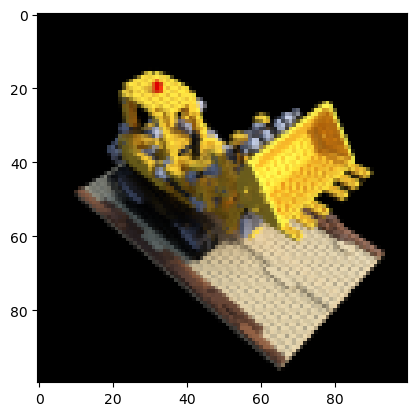

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


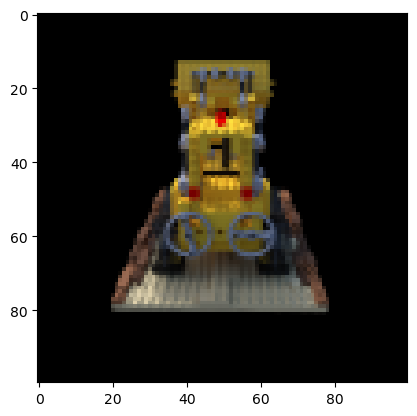

[[ 5.2186674e-01  1.8684424e-01 -8.3231264e-01 -3.3551595e+00]
 [-8.5302705e-01  1.1430796e-01 -5.0919402e-01 -2.0526268e+00]
 [-7.4505806e-09  9.7571665e-01  2.1903668e-01  8.8296509e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


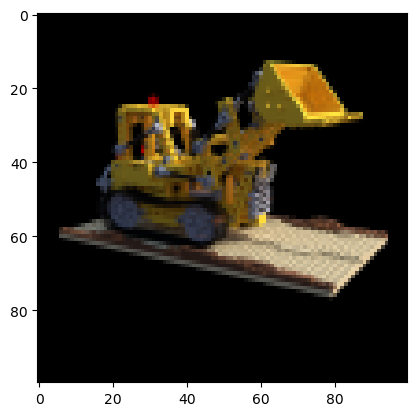

[[ 8.4227312e-01 -2.5616011e-01  4.7429734e-01  1.9119539e+00]
 [ 5.3905100e-01  4.0025294e-01 -7.4109477e-01 -2.9874487e+00]
 [ 1.4901161e-08  8.7987477e-01  4.7520566e-01  1.9156154e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


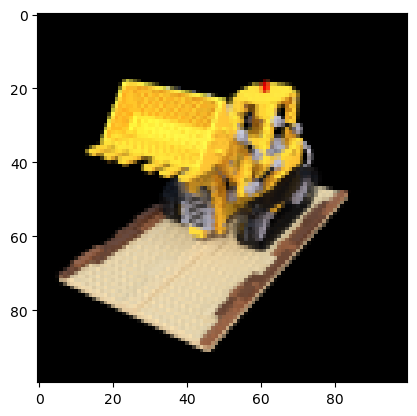

[[-0.2867389  -0.8562213   0.4297276   1.7322875 ]
 [ 0.95800877 -0.25627318  0.12862055  0.5184861 ]
 [ 0.          0.44856343  0.89375097  3.6028256 ]
 [ 0.          0.          0.          1.        ]]


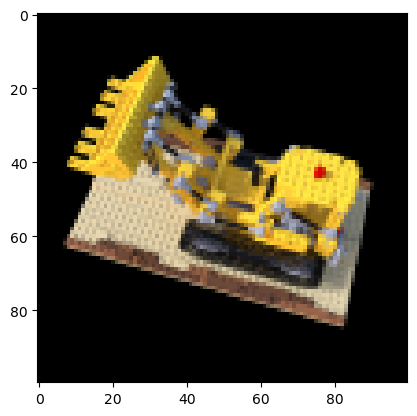

In [8]:
for i in range(4):
    print(poses[i*10])
    plt.imshow(images[i*10])
    plt.show()

# Optimize NeRF

In [5]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [15]:
rays_o=np.zeros(100*100*3).reshape(100,100,3)
N_samples=64
far=6.0
near=2.0
z_vals=tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
tf.random.uniform((100,100,64))
a=np.array([[[1,2],[3,4]],[[5,6],[7,8]]])
print(rays_o[...,None,:].shape)
print(z_vals[...,None].shape)
pts = rays_o[...,None,:] + rays_o[...,None,:] * z_vals[...,:,None]
tf.reshape(pts,[-1,3])
tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 


(100, 100, 1, 3)
(100, 100, 64, 1)


<tf.Tensor: id=590, shape=(100, 100, 64), dtype=float32, numpy=
array([[[-3.32621709e-02,  4.00408655e-02, -4.79054153e-02, ...,
          2.45876908e-02,  2.06368789e-02,  1.00000000e+10],
        [-8.17089528e-03,  6.44174963e-03,  1.41672939e-02, ...,
         -1.72535405e-02,  3.40294838e-03,  1.00000000e+10],
        [-1.41597688e-02,  1.39969140e-02, -4.50752378e-02, ...,
          4.91198376e-02,  1.75303221e-03,  1.00000000e+10],
        ...,
        [-5.25299609e-02,  3.63411754e-03, -3.96214426e-03, ...,
         -3.96237373e-02, -1.04102790e-02,  1.00000000e+10],
        [ 3.05114463e-02, -4.27145883e-02,  1.72085166e-02, ...,
         -1.13286152e-02,  1.96372420e-02,  1.00000000e+10],
        [ 2.43439078e-02, -3.28345895e-02, -1.08493790e-02, ...,
         -3.59543040e-02, -9.37357545e-05,  1.00000000e+10]],

       [[ 1.81592256e-02, -7.92352110e-03,  2.67058089e-02, ...,
         -4.23124656e-02, -5.99385053e-03,  1.00000000e+10],
        [-1.97063610e-02, -3.75195593e-

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.27471723556518557 secs per iter


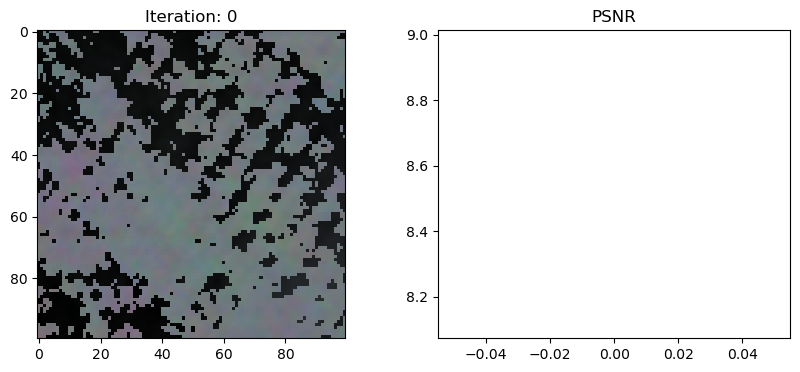

25 2.5838983058929443 secs per iter


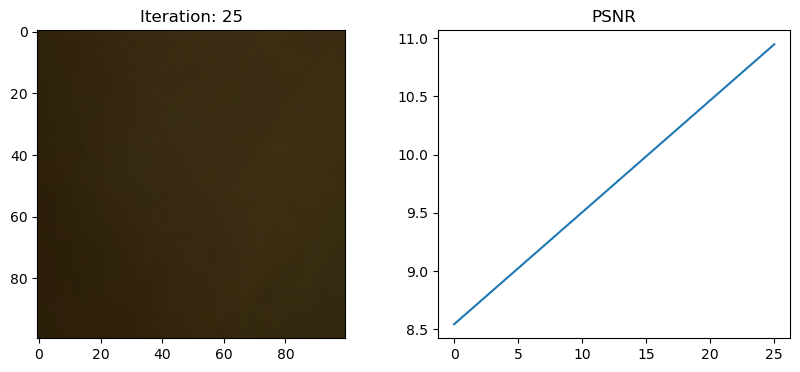

50 2.6030623149871825 secs per iter


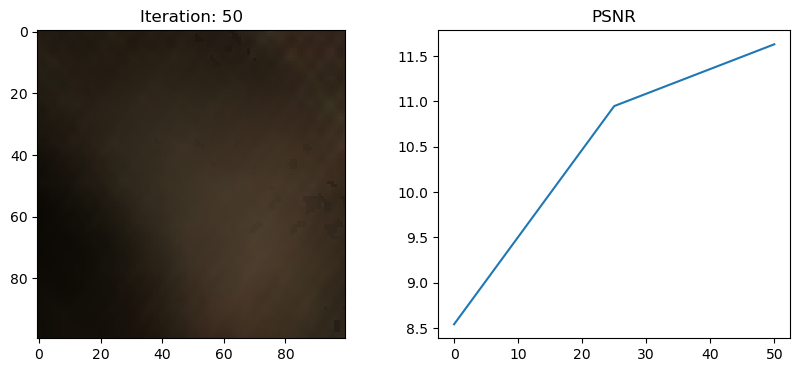

75 2.5658320331573488 secs per iter


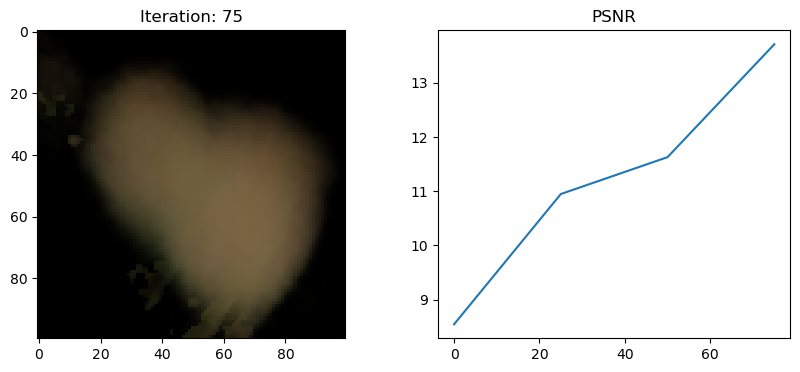

100 2.6538540172576903 secs per iter


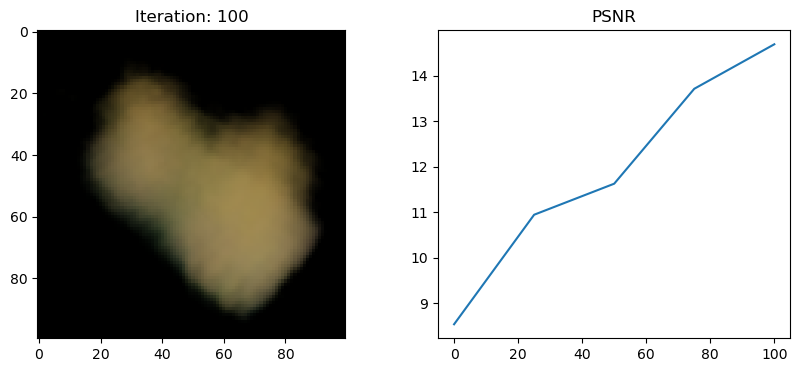

125 4.671761837005615 secs per iter


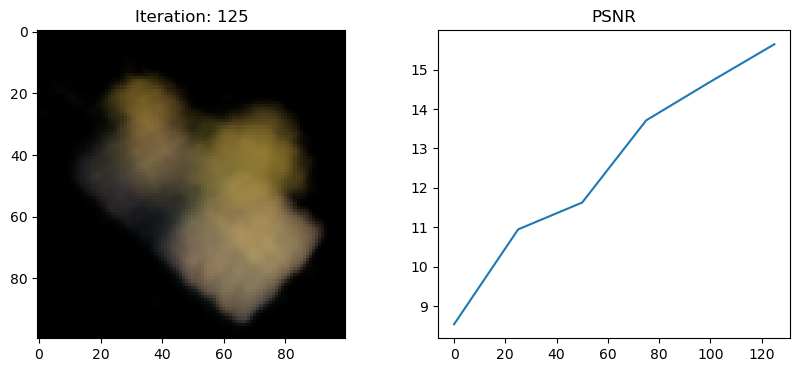

150 3.6411742782592773 secs per iter


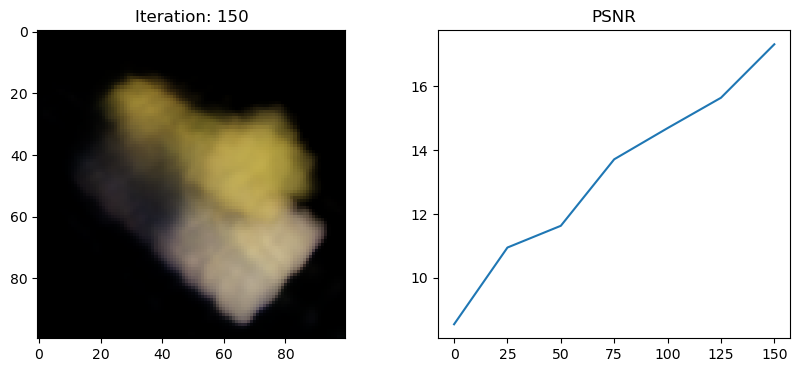

175 4.464872131347656 secs per iter


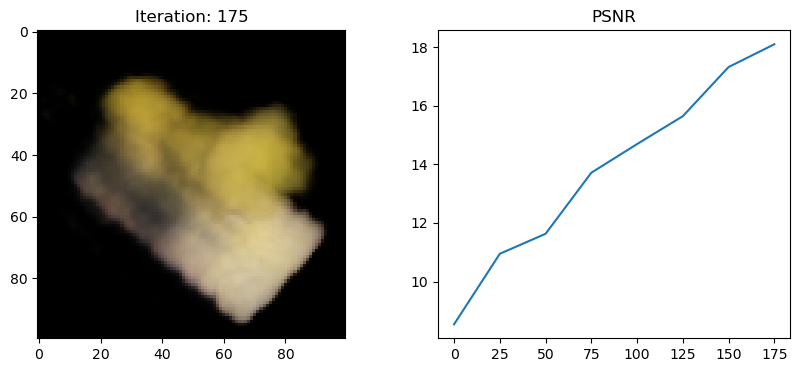

200 4.92300051689148 secs per iter


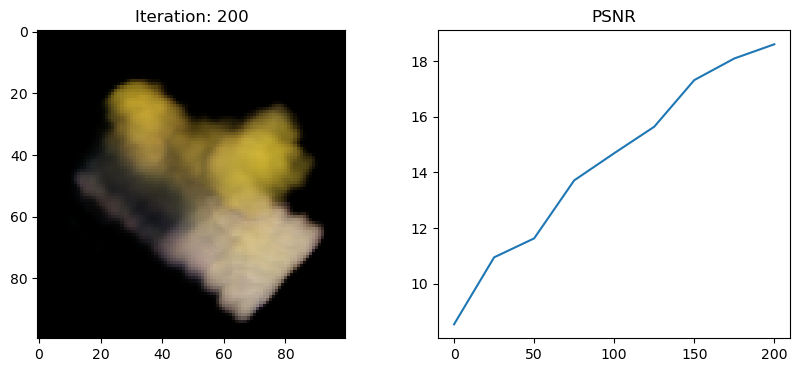

225 3.1238678646087648 secs per iter


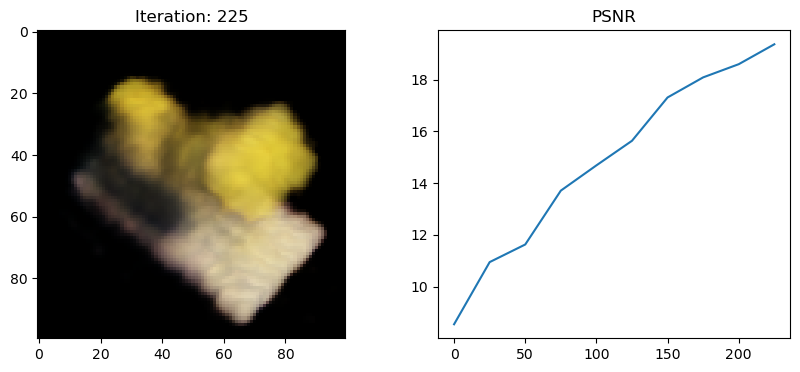

250 2.5112818622589113 secs per iter


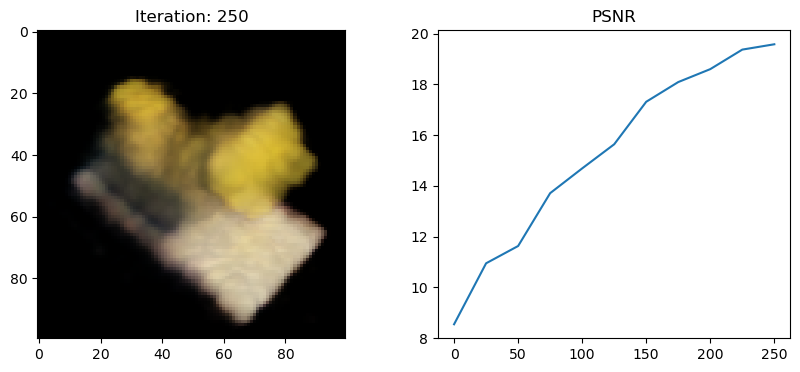

275 2.528880434036255 secs per iter


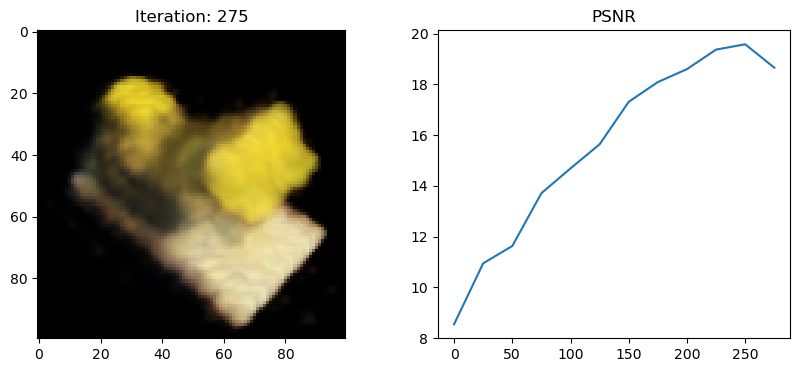

300 2.5650947666168213 secs per iter


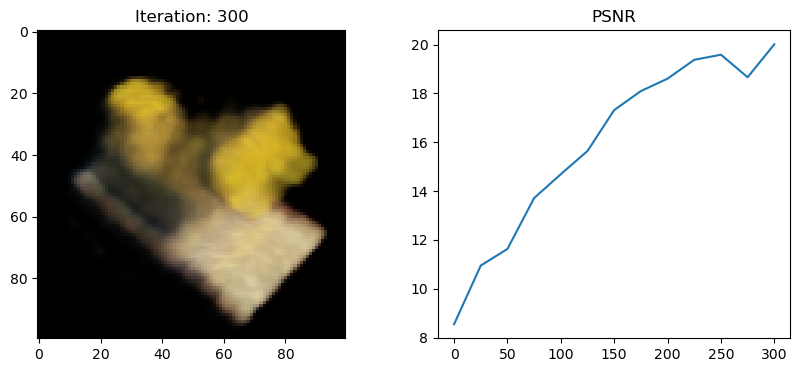

325 2.495945234298706 secs per iter


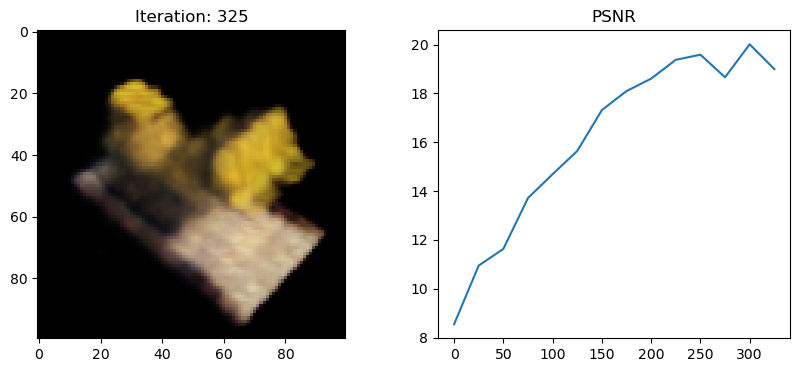

350 2.4709491539001465 secs per iter


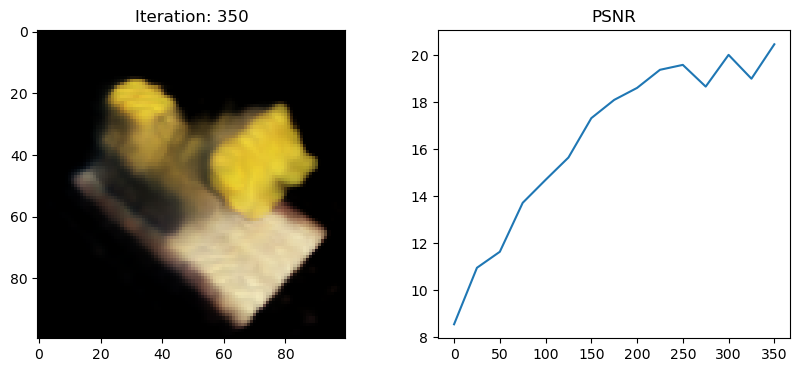

375 2.5497143268585205 secs per iter


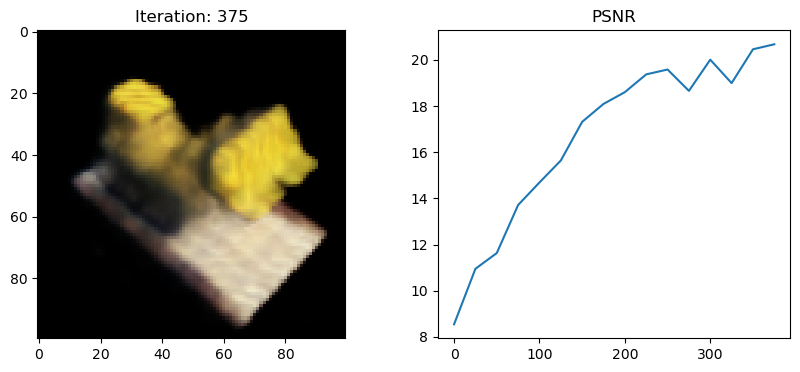

400 2.580621747970581 secs per iter


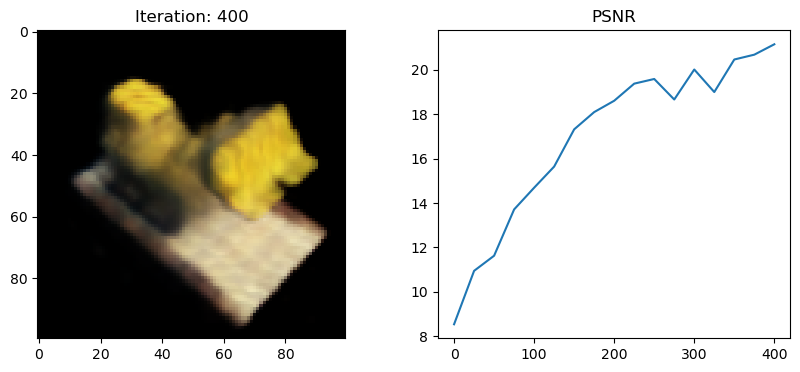

425 2.6918748474121093 secs per iter


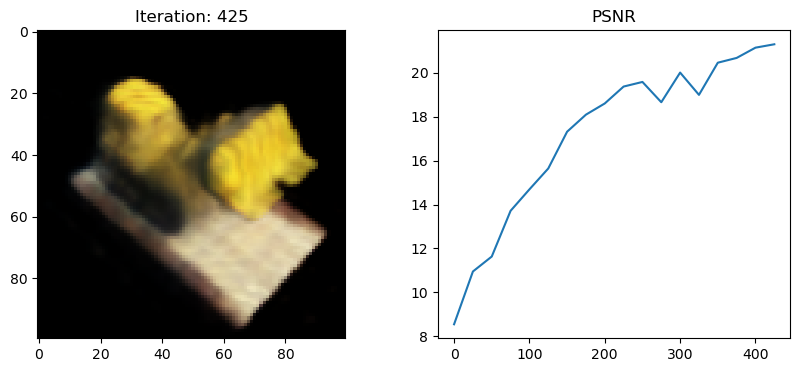

450 2.6273397636413574 secs per iter


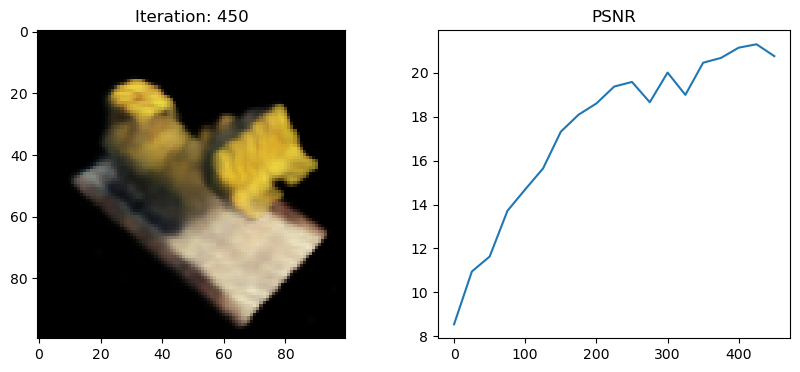

475 2.625089340209961 secs per iter


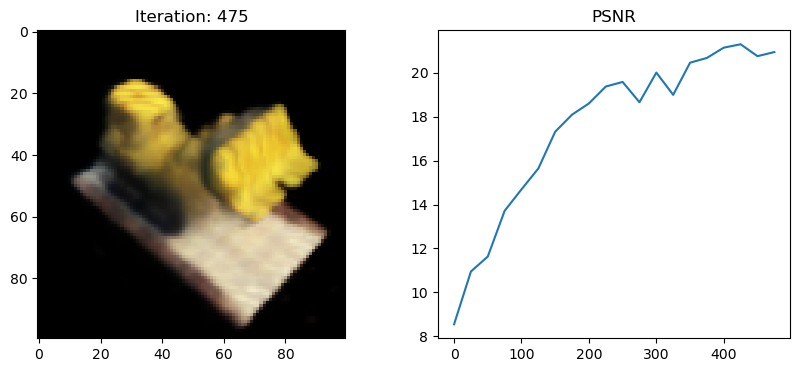

500 2.621452178955078 secs per iter


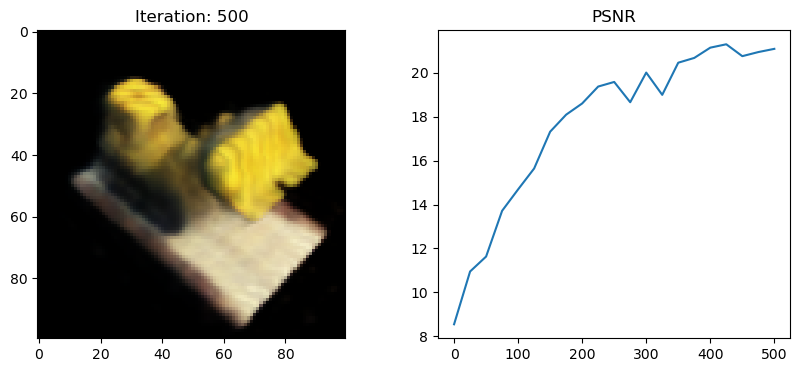

525 2.519394187927246 secs per iter


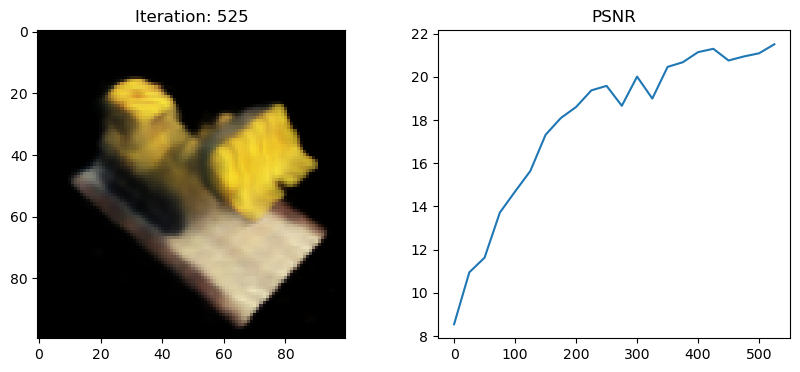

550 2.579846487045288 secs per iter


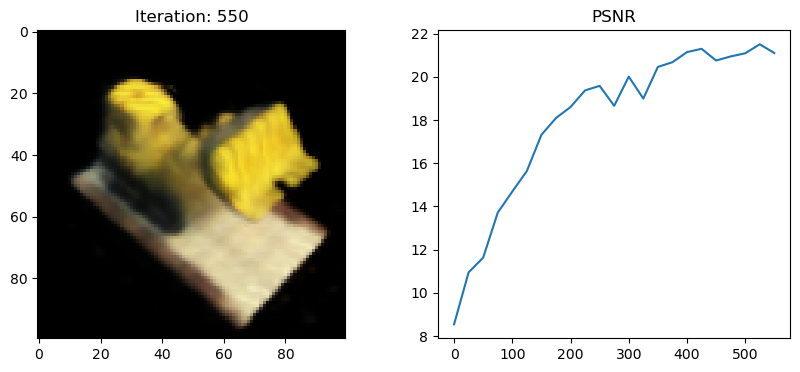

575 2.573877115249634 secs per iter


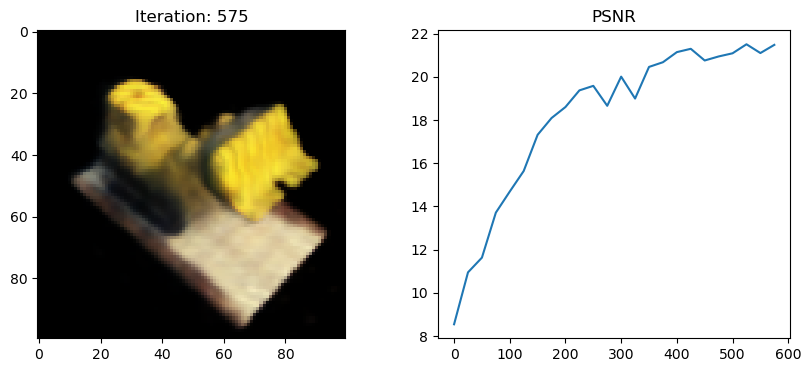

600 2.577279806137085 secs per iter


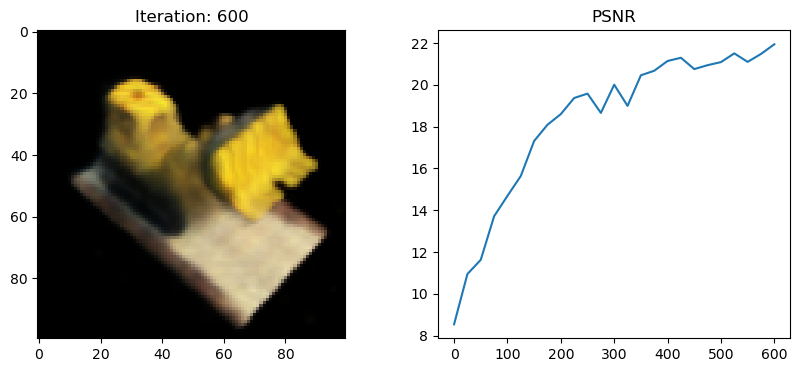

625 2.586131114959717 secs per iter


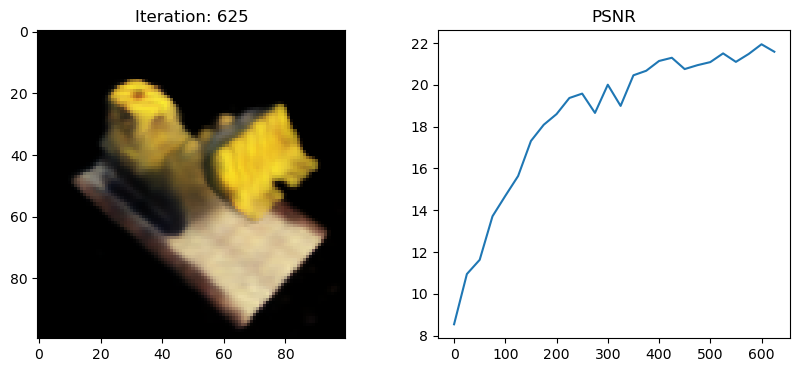

650 2.5809563636779784 secs per iter


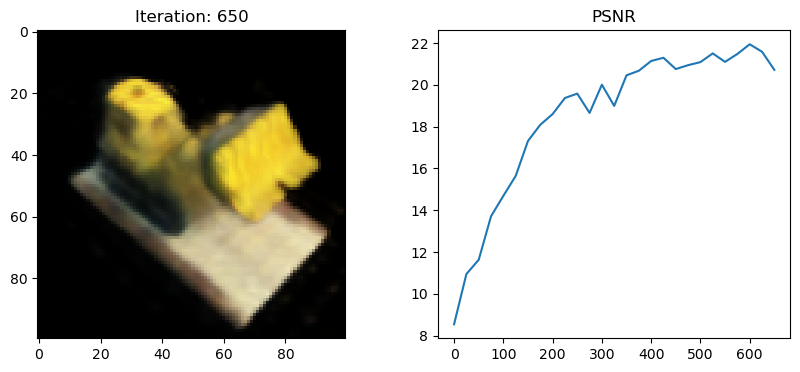

675 2.6332175731658936 secs per iter


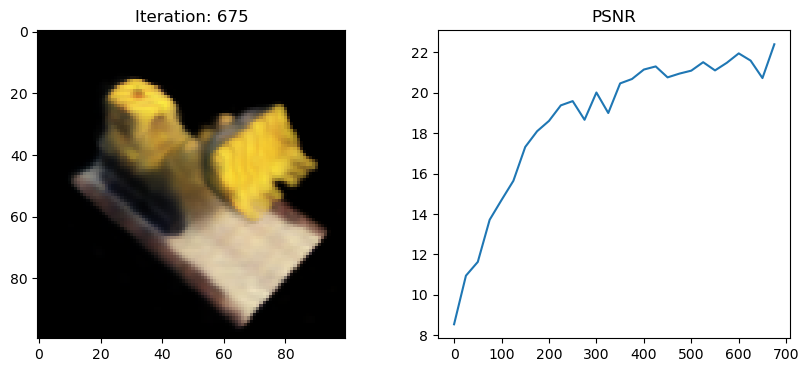

700 2.6034464263916015 secs per iter


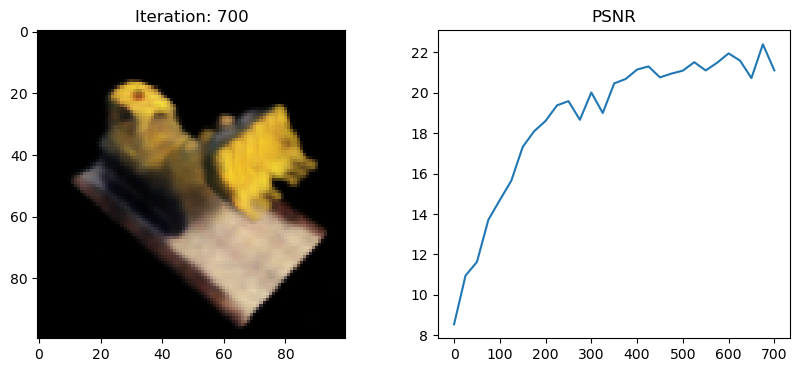

725 2.6291262245178224 secs per iter


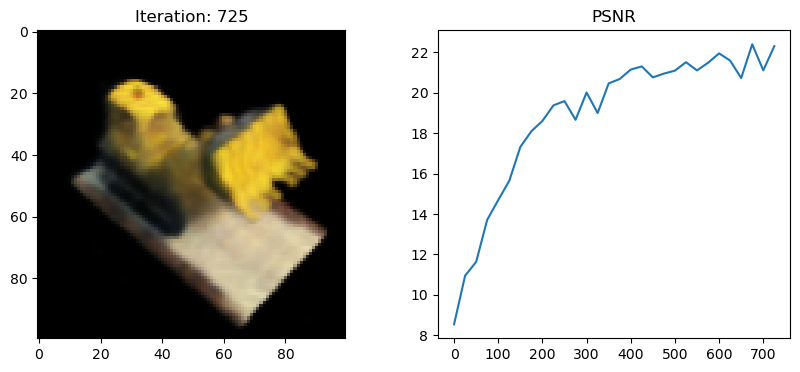

750 2.6915844917297362 secs per iter


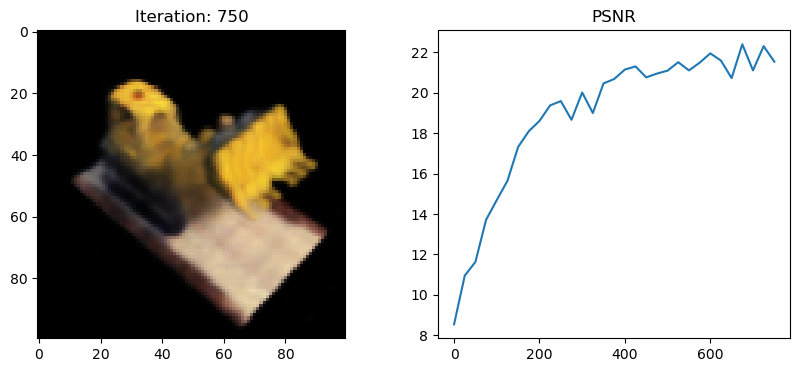

775 2.6521786975860597 secs per iter


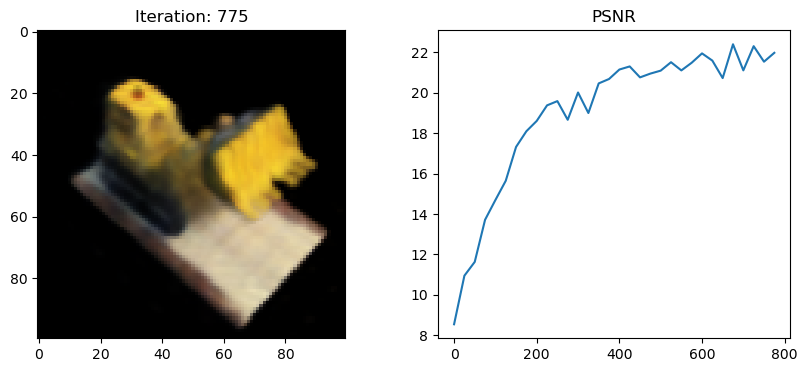

800 2.7095119190216064 secs per iter


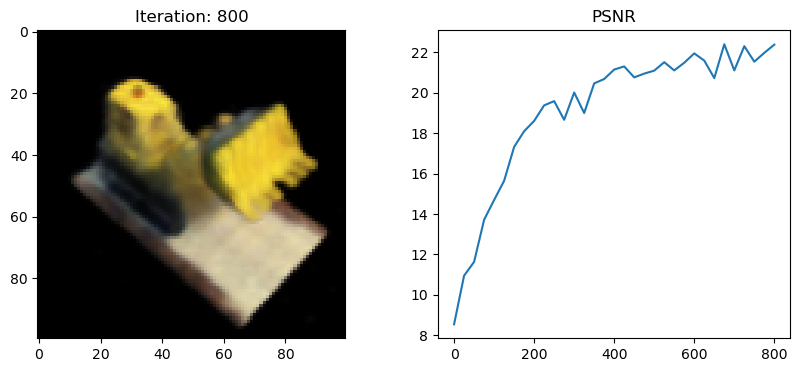

825 2.929595127105713 secs per iter


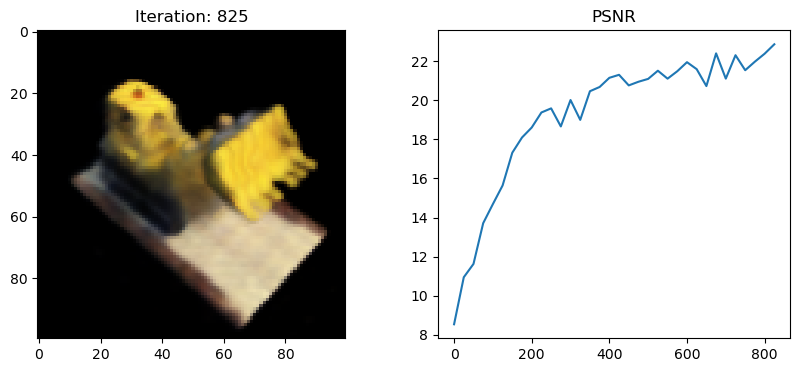

850 2.533919105529785 secs per iter


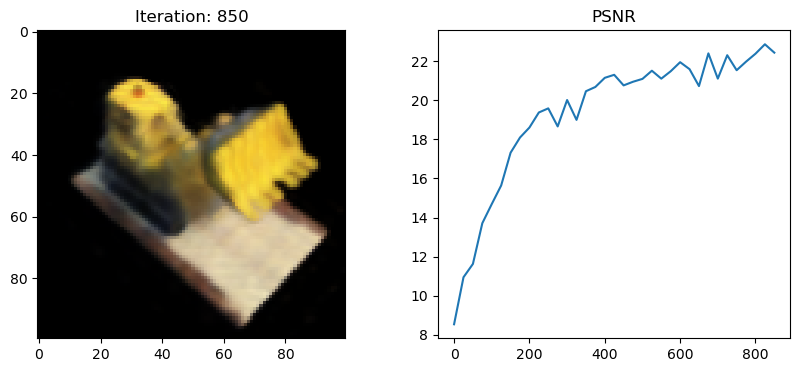

875 2.5642669105529787 secs per iter


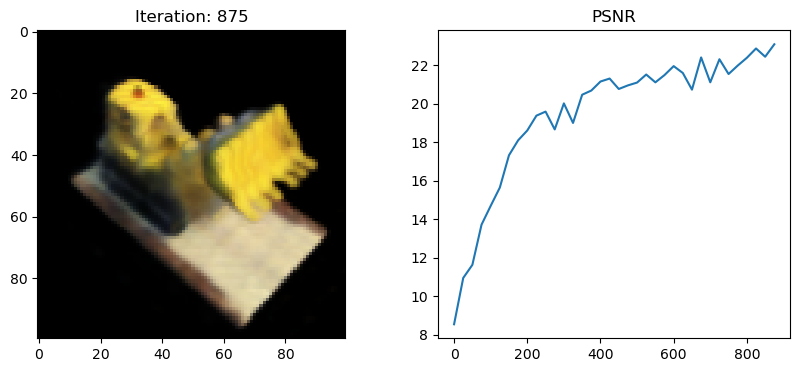

900 2.5519920349121095 secs per iter


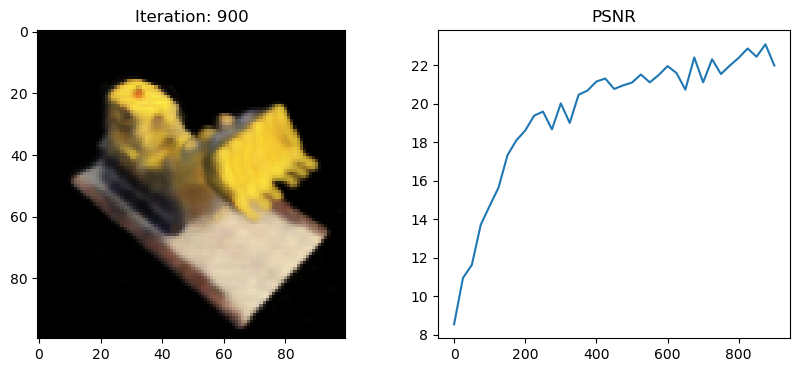

925 2.6054670715332033 secs per iter


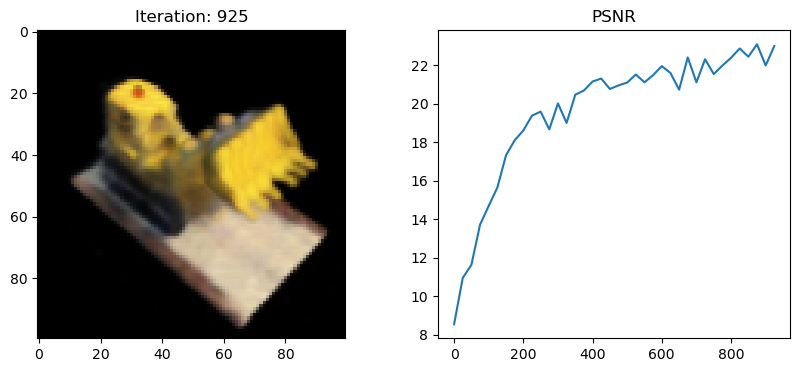

950 2.616161308288574 secs per iter


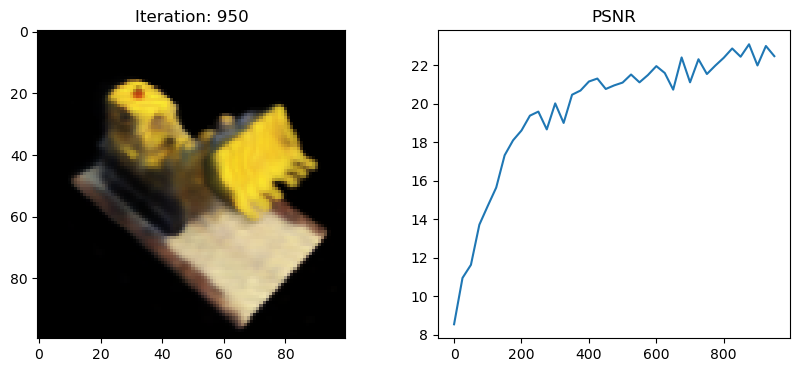

975 2.5812150192260743 secs per iter


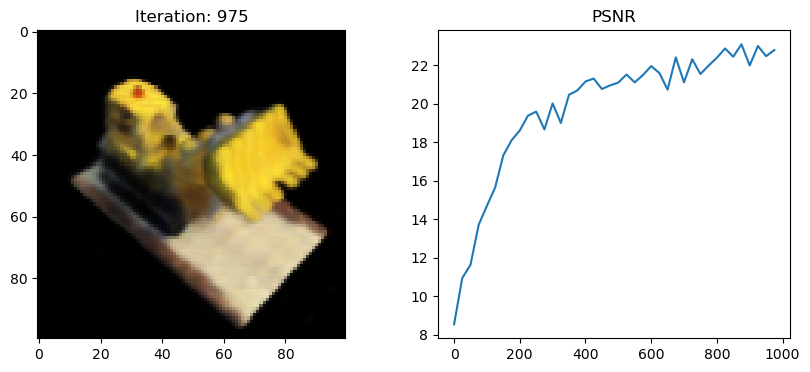

1000 2.593291187286377 secs per iter


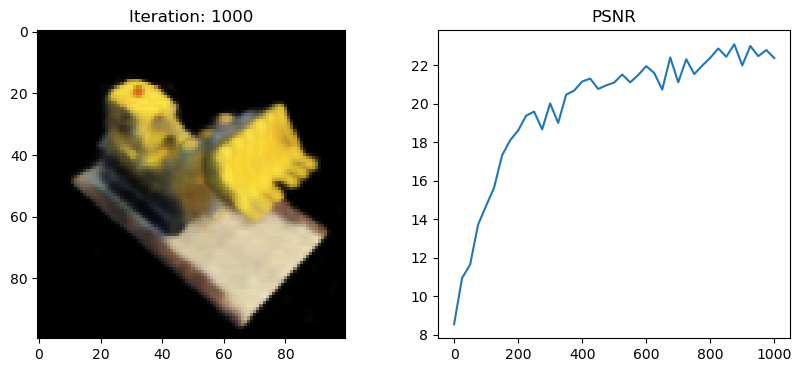

Done


In [6]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

In [16]:
print(rays_d)

tf.Tensor(
[[[ 0.43379948  0.9097397  -0.49334717]
  [ 0.43876278  0.9045238  -0.49334717]
  [ 0.44372612  0.8993079  -0.49334717]
  ...
  [ 0.91524243  0.40379962 -0.49334717]
  [ 0.9202057   0.39858377 -0.49334717]
  [ 0.92516905  0.3933679  -0.49334717]]

 [[ 0.42995661  0.90608287 -0.49821544]
  [ 0.43491995  0.900867   -0.49821544]
  [ 0.4398833   0.8956511  -0.49821544]
  ...
  [ 0.91139954  0.40014285 -0.49821544]
  [ 0.9163629   0.39492697 -0.49821544]
  [ 0.9213262   0.38971108 -0.49821544]]

 [[ 0.42611375  0.90242606 -0.50308377]
  [ 0.43107706  0.8972102  -0.50308377]
  [ 0.4360404   0.8919943  -0.50308377]
  ...
  [ 0.90755665  0.39648604 -0.50308377]
  [ 0.91252     0.39127016 -0.50308377]
  [ 0.9174833   0.38605428 -0.50308377]]

 ...

 [[ 0.06104216  0.5550309  -0.9655718 ]
  [ 0.06600547  0.549815   -0.9655718 ]
  [ 0.07096881  0.5445991  -0.9655718 ]
  ...
  [ 0.5424851   0.04909083 -0.9655718 ]
  [ 0.5474484   0.04387498 -0.9655718 ]
  [ 0.55241174  0.0386591  -0.965

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)